In [ ]:
"""Neuron / DEAP optimisation example using a cerebellar Granule cell model (D'Angelo et al. 2001)"""

# These scripts were developed (partly based on existing code) during the 2015 HBP Summit Hackathon
# by 
# Werner Van Geit @ BlueBrain Project  
# Stefan Masoli @ Department of Brain and Behavioral Sciences, Pavia University, Pavia

import neuron
neuron.h.load_file('stdrun.hoc')

import efel
import numpy as np

# dictionary with all the original conductances
import collections
orig_conductances = collections.OrderedDict()
orig_conductances['GrC_CaHVA'] = 0.00046
orig_conductances['GrC_KA'] = 0.004
orig_conductances['GrC_Lkg1'] = 5.68e-5
orig_conductances['GrG_KM'] = 0.00035
orig_conductances['Calc'] = 1.5
orig_conductances['GrC_KCa'] = 0.004
orig_conductances['GrC_Kir'] = 0.0009
orig_conductances['GrC_Lkg2'] = 2.17e-5
orig_conductances['GrC_pNa'] = 2e-5
orig_conductances['GrG_KV'] = 0.003
orig_conductances['GrG_Na'] = 0.013
orig_conductances['GrG_Nar'] = 0.0005

import deap.gp
from deap import base
from deap import creator
from deap import tools
from bluepyopt.deapext.tools import selIBEA
import bluepyopt.deapext.algorithms

In [2]:
%matplotlib inline
import pylab
pylab.rcParams['figure.figsize'] = 20, 12
from IPython import display

In [ ]:
!nrnivmodl ./mechanisms

In [ ]:
def get_features(conductances):
    import GranuleCell1 as grcsteps

    import collections

    feature_values = collections.defaultdict(dict)

    traces = []

    times = []
    voltages = []
    for step_number in range(3):
        time, voltage = grcsteps.steps(step_number, conductances)

        trace = {}  # dictionary with time, voltage start and end vectors.
        trace['T'] = time
        trace['V'] = voltage
        trace['stim_start'] = [100]
        trace['stim_end'] = [500]
        traces = [trace]  # a think is a list from a dictionary

        result = efel.getFeatureValues(
            traces, [
                'voltage_base', 'Spikecount', 'min_voltage_between_spikes', 'AP_height', 'steady_state_voltage_stimend'])

        for feature_name, feature_list in result[0].items():
            if feature_list is not None and len(feature_list) > 0:
                feature_values[step_number][
                    feature_name] = np.mean(feature_list)
            else:
                feature_values[step_number][feature_name] = None
                
        times.append(time)
        voltages.append(voltage)
        
    return feature_values, times, voltages

orig_features, orig_times, orig_voltages = get_features(orig_conductances)

# it doesn't work with classes, at least at thi point

In [5]:
def evaluate(individual):
    """
    Evaluate a neuron model with parameters e_pas and g_pas, extracts
    features from resulting traces and returns a tuple with
    abs(voltage_base-target_voltage1) and
    abs(steady_state_voltage-target_voltage2)
    """

    conductances = dict()

    for conductance_number, key in enumerate(orig_conductances.keys()):
        conductances[key] = individual[conductance_number]

    new_features, times, voltages = get_features(conductances)
    individual.times = times
    individual.voltages = voltages
    obj_values = compare_features(orig_features, new_features)
    
    individual.tot_fitness = sum(obj_values)
    
    return obj_values    

In [6]:
def plot_selector(population, k, selector=None, **kwargs):  

    for index in range(3):
        pylab.subplot(4, 1, index+1)
        pylab.cla()
        for ind in population:
            time = ind.times[index]
            voltage = ind.voltages[index]
            pylab.plot(time, voltage, color='black', alpha=0.05)

        import operator
        best_ind = min(population, key=operator.attrgetter("tot_fitness"))
        # print best_ind, best_ind.fitness
        time = best_ind.times[index]
        voltage = best_ind.voltages[index]
        # target_voltage1 = best_ind.target_voltage1
        # target_voltage2 = best_ind.target_voltage2

        pylab.plot(orig_times[index], orig_voltages[index], color='blue', linewidth=3) 
        pylab.plot(time, voltage, color='red', linewidth=3) 
        # pylab.plot(time, numpy.ones(len(time))*target_voltage1, '--', color='black')
        # pylab.plot(time, numpy.ones(len(time))*target_voltage2, '--', color='black')
        pylab.ylim(-100, 50)
        pylab.xlabel('Time (ms)')
        pylab.ylabel('Membrane voltage (mv)')

    
    pylab.subplot(4, 1, 4)
    pylab.cla()
    # for ind in population:
    #     pylab.plot([ind.fitness.values[0]], [ind.fitness.values[1]], 'o', color='grey', alpha=0.2, markersize=15)
    # pylab.plot([best_ind.fitness.values[0]], [best_ind.fitness.values[1]], 'o', color='red', markersize=15)
    pylab.bar(range(len(best_ind.fitness.values)), best_ind.fitness.values, color='red')
    pylab.ylim(0, 10)
    pylab.ylabel('Feature errors')
    pylab.xlabel('Features')
    
    display.clear_output(wait=True)
    pylab.draw()
    display.display(pylab.gcf())
    pylab.pause(0.5)
    
    selected_pop = selector(population, k, **kwargs)
    
    return selected_pop

In [7]:
def compare_features(orig_features, new_features):

    obj_values = []
    for step_number in orig_features:
        for feature_name, feature_value in orig_features[step_number].items():
            if feature_value is not None:
                # print new_features
                # print step_number, feature_name
                if new_features[step_number][feature_name] is None:
                    obj_values.append(250.0)
                else:
                    obj_values.append(
                        abs(new_features
                            [step_number][feature_name] -
                            feature_value))

    return obj_values

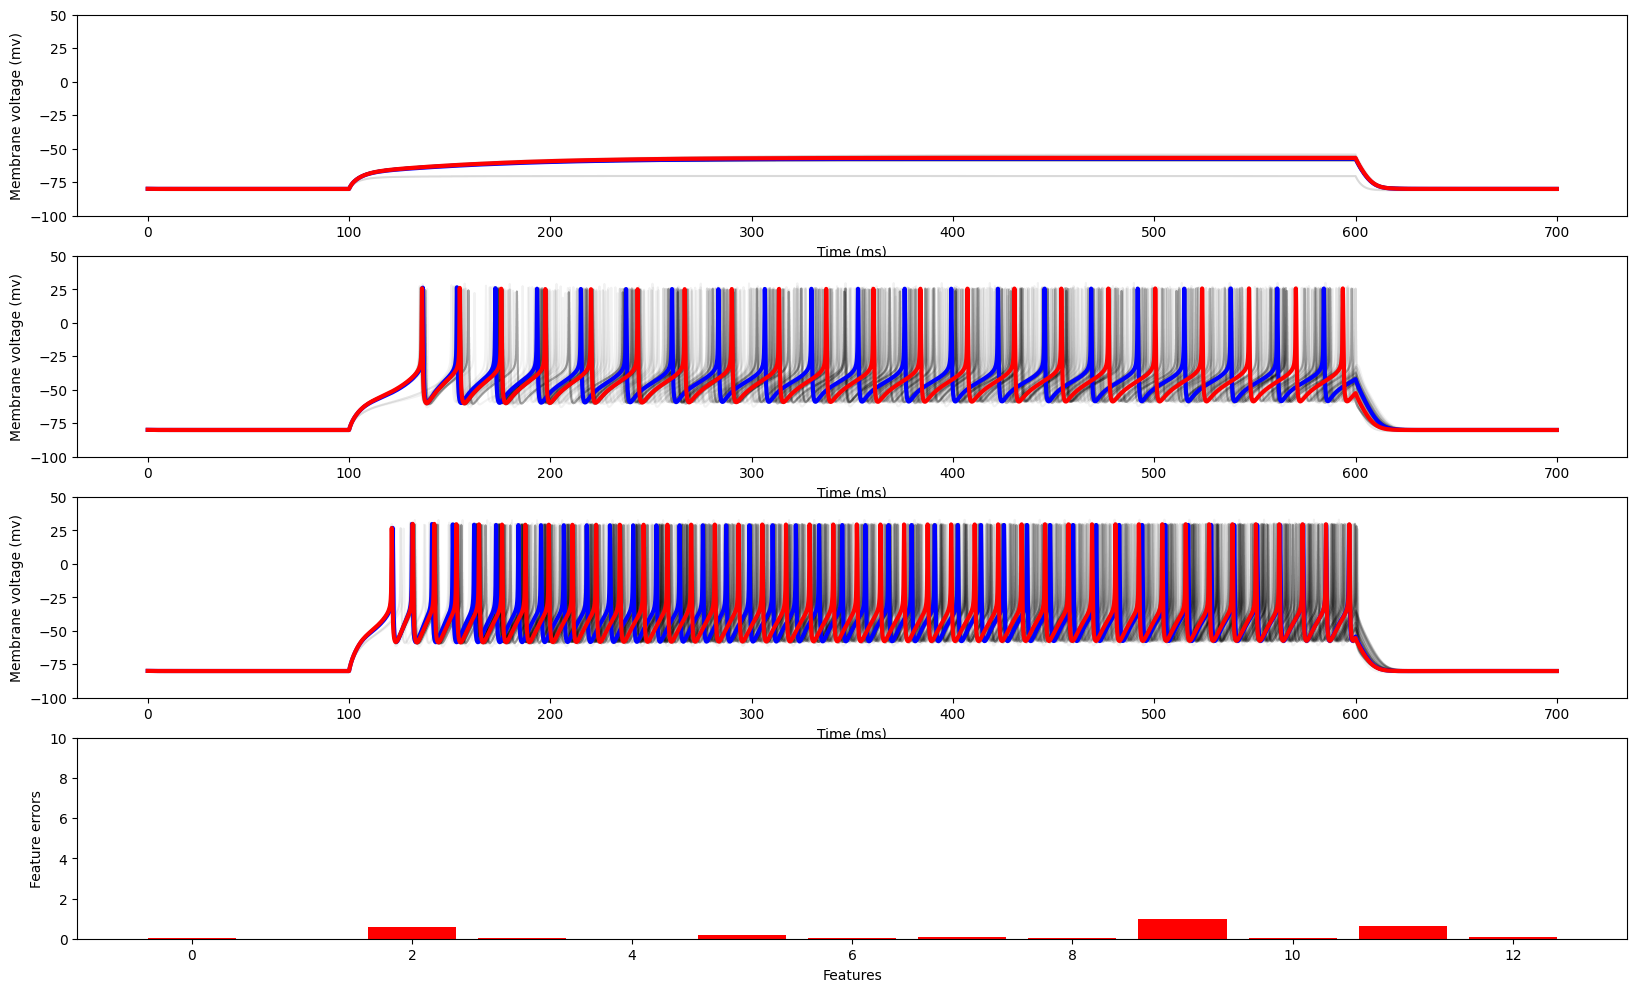

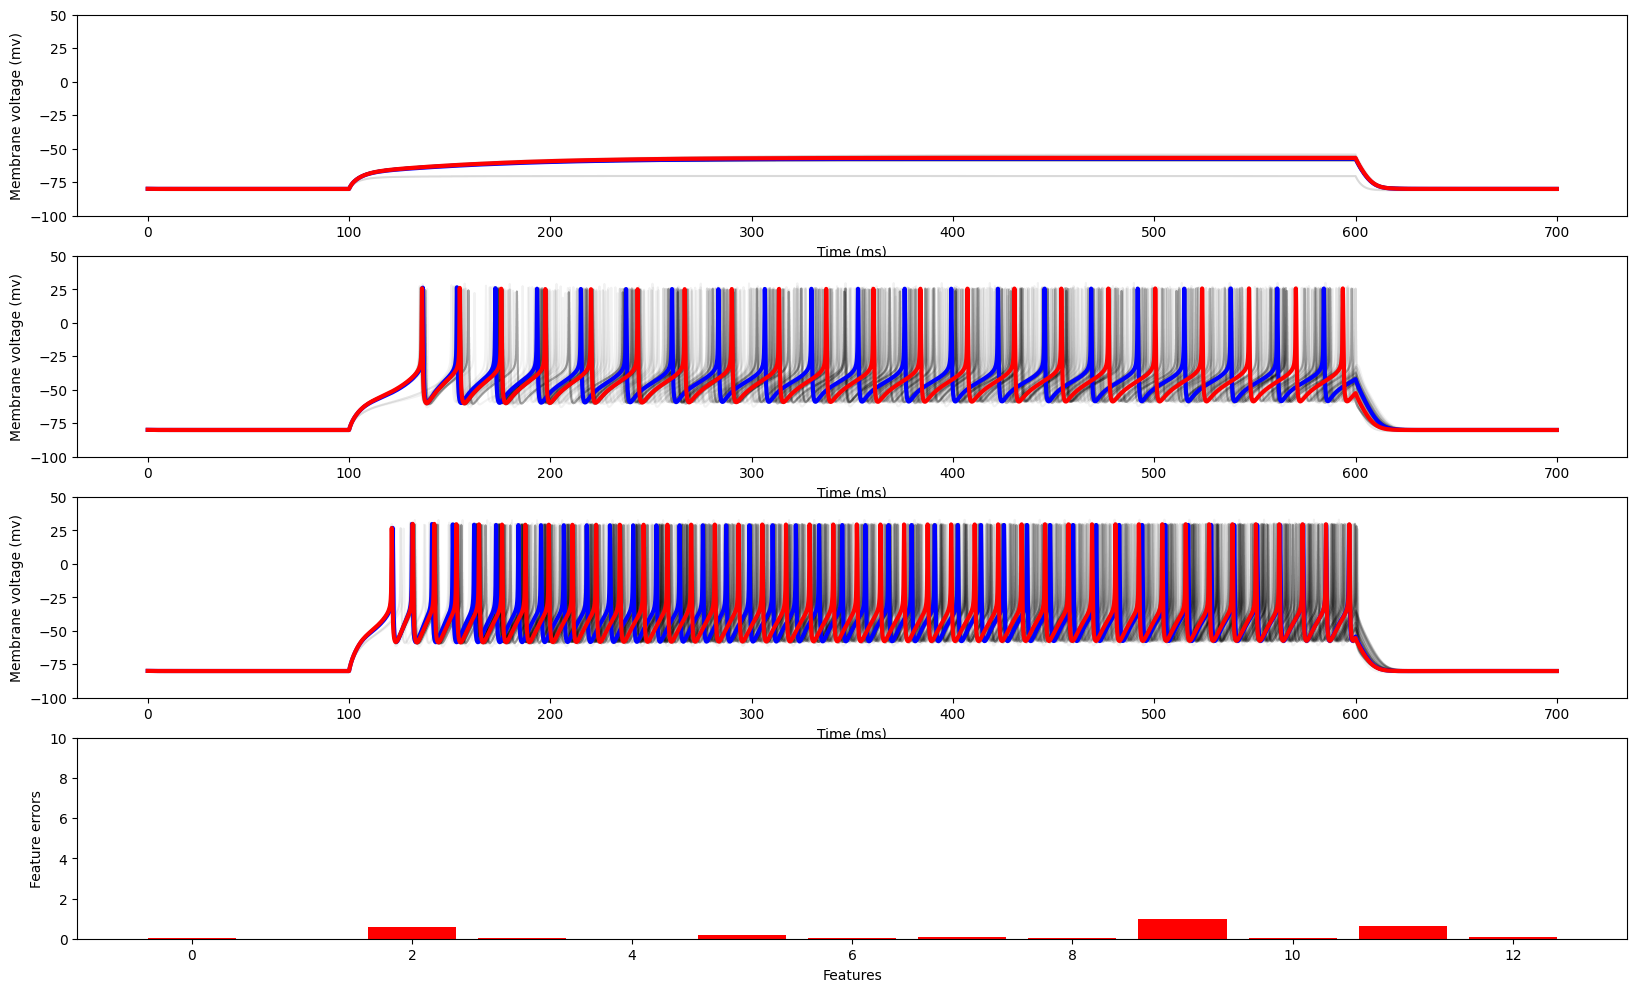

In [8]:
def main():

    import random
    # Set random seed
    random.seed(1)

    # Set number of individuals in population
    POP_SIZE = 50

    # Set number of individuals to create in every offspring
    OFFSPRING_SIZE = 50

    # Total number of generation to run
    NGEN = 100

    # Total population size of EA
    ALPHA = POP_SIZE
    # Total parent population size of EA
    MU = OFFSPRING_SIZE
    # Total offspring size of EA
    LAMBDA = OFFSPRING_SIZE

    # Crossover, mutation probabilities
    CXPB = 0.7
    MUTPB = 0.3

    # Eta parameter of crossover / mutation parameters
    # Basically defines how much they 'spread' solution around
    # The higher this value, the more spread
    ETA = 10.0

    # Number of parameters
    IND_SIZE = 12

    # Number of objectives
    OBJ_SIZE = 13

    # Bounds for the parameters

    LOWER = []
    UPPER = []

    for key, value in orig_conductances.items():
        LOWER.append(value - 1.0 * abs(value))
        UPPER.append(value + 1.0 * abs(value))

    # Create a fitness function
    # By default DEAP selector will try to optimise fitness values,
    # so we add a -1 weight value to minise
    creator.create("Fitness", base.Fitness, weights=[-1.0] * OBJ_SIZE)

    class Individual(list):

        def __init__(self, *args):
            list.__init__(self, *args)
            self.time = None
            self.voltage = None

    # Create an individual that consists of a list
    creator.create("Individual", Individual, fitness=creator.Fitness)

    # Define a function that will uniformly pick an individual
    def uniform(lower_list, upper_list, dimensions):
        """Fill array """

        if hasattr(lower_list, '__iter__'):
            return [random.uniform(lower, upper) for lower, upper in
                    zip(lower_list, upper_list)]
        else:
            return [random.uniform(lower_list, upper_list)
                    for _ in range(dimensions)]

    # Create a DEAP toolbox
    toolbox = base.Toolbox()

    # Register the 'uniform' function
    toolbox.register("uniformparams", uniform, LOWER, UPPER, IND_SIZE)

    # Register the individual format
    # An indiviual is create by 'creator.Individual' and parameters are initially
    # picked by 'uniform'
    toolbox.register(
        "Individual",
        tools.initIterate,
        creator.Individual,
        toolbox.uniformparams)

    # Register the population format. It is a list of individuals
    toolbox.register("population", tools.initRepeat, list, toolbox.Individual)

    # Register the evaluation function for the individuals
    # import deap_efel_eval1
    toolbox.register("evaluate", evaluate)

    # Register the mate operator
    toolbox.register(
        "mate",
        deap.tools.cxSimulatedBinaryBounded,
        eta=ETA,
        low=LOWER,
        up=UPPER)

    # Register the mutation operator
    toolbox.register("mutate", deap.tools.mutPolynomialBounded, eta=ETA,
                     low=LOWER, up=UPPER, indpb=0.1)

    # Register the variate operator
    toolbox.register("variate", deap.algorithms.varAnd)

    # Register the selector (picks parents from population)
    toolbox.register("select", plot_selector, selector=selIBEA)

    # toolbox.register("select", tools.selIBEA)
    # toolbox.register("select", tools.selIBEA)

    # Generate the population object
    pop = toolbox.population(n=MU)

    pop, hof, log, history = bluepyopt.deapext.algorithms.eaAlphaMuPlusLambdaCheckpoint(
        pop,
        toolbox,
        MU,
        CXPB,
        1 - CXPB,
        NGEN)

main()